**Prepare training data from Metadata file**

In [13]:
import pandas as pd
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Read metadata file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CNN/Pocket Sounds vs Pocket Coughs/metadata/metadata.csv')
df['relative_path'] = '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)
df = df[['relative_path', 'classID']]

Mounted at /content/drive


**AudioToolkit helper class definition**

In [14]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioToolkit():
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud
    if (sig.shape[0] == new_channel):
      return aud
    else:
      resig = torch.cat([sig, sig])
    return ((resig, sr))

  @staticmethod
  def padding(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms
    if (sig_len > max_len):
      sig = sig[:,:max_len]
    elif (sig_len < max_len):
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))
      sig = torch.cat((pad_begin, sig, pad_end), 1)     
    return (sig, sr)

  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

**Define Custom Data Loader**

In [15]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 2000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4

  def __len__(self):
    return len(self.df)    

  def __getitem__(self, idx):
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    class_id = self.df.loc[idx, 'classID']
    aud = torchaudio.load(audio_file)
    rechan = AudioToolkit.rechannel(aud, self.channel)
    dur_aud = AudioToolkit.padding(rechan, self.duration)
    sgram = AudioToolkit.spectro_gram(dur_aud, 64, 1024)
    return sgram, class_id

**Prepare Batches of Data with the Data Loader**

In [16]:
from torch.utils.data import random_split
myds = SoundDS(df, '/content/drive/MyDrive/Colab Notebooks/CNN/Pocket Sounds vs Pocket Coughs/audio')
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

**Create Model**

In [17]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

class AudioClassifier (nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        self.conv = nn.Sequential(*conv_layers)
 
    def forward(self, x):
        x = self.conv(x)
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        return x

myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
next(myModel.parameters()).device

device(type='cpu')

**Training**

Epoch: 0, Loss: 2.12, Accuracy: 0.43
Epoch: 1, Loss: 1.65, Accuracy: 0.74
Epoch: 2, Loss: 1.17, Accuracy: 0.82
Epoch: 3, Loss: 0.87, Accuracy: 0.87
Epoch: 4, Loss: 0.89, Accuracy: 0.83
Epoch: 5, Loss: 0.52, Accuracy: 0.91
Epoch: 6, Loss: 0.25, Accuracy: 0.95
Epoch: 7, Loss: 0.24, Accuracy: 0.94
Epoch: 8, Loss: 0.15, Accuracy: 0.97
Epoch: 9, Loss: 0.15, Accuracy: 0.95
Epoch: 10, Loss: 0.21, Accuracy: 0.93
Epoch: 11, Loss: 0.13, Accuracy: 0.96
Epoch: 12, Loss: 0.08, Accuracy: 0.98
Epoch: 13, Loss: 0.10, Accuracy: 0.96
Epoch: 14, Loss: 0.11, Accuracy: 0.97
Epoch: 15, Loss: 0.19, Accuracy: 0.95
Epoch: 16, Loss: 0.11, Accuracy: 0.96
Epoch: 17, Loss: 0.12, Accuracy: 0.95
Epoch: 18, Loss: 0.11, Accuracy: 0.97
Epoch: 19, Loss: 0.14, Accuracy: 0.96
Epoch: 20, Loss: 0.38, Accuracy: 0.88
Epoch: 21, Loss: 0.12, Accuracy: 0.96
Epoch: 22, Loss: 0.11, Accuracy: 0.95
Epoch: 23, Loss: 0.18, Accuracy: 0.92
Epoch: 24, Loss: 0.08, Accuracy: 0.98
Epoch: 25, Loss: 0.05, Accuracy: 0.99
Epoch: 26, Loss: 0.06,

Text(0.5, 1.0, 'Loss over time for 0.01')

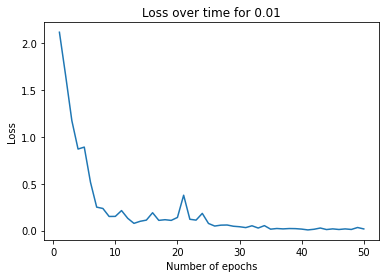

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def training(model, train_dl, num_epochs, lr):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  loss_vals = []
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    epoch_loss = []

    for i, data in enumerate(train_dl):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        _, prediction = torch.max(outputs,1)
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))

  print('Finished Training')
  plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)
  
num_epochs=50   # Just for demo, adjust this higher
#myModel = AudioClassifier()
#training(myModel, train_dl, num_epochs, 0.001)
myModel = AudioClassifier()
training(myModel, train_dl, num_epochs, 0.01)
#myModel = AudioClassifier()
#training(myModel, train_dl, num_epochs, 0.1)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title("Loss over time for 0.01")
#blue_patch = mpatches.Patch(color='blue', label='0.001')
#orange_patch = mpatches.Patch(color='orange', label='0.01')
#green_patch = mpatches.Patch(color='green', label='0.1')
#plt.legend(handles=[blue_patch, orange_patch, green_patch])

**Inference**

Accuracy: 1.00, Total items: 56


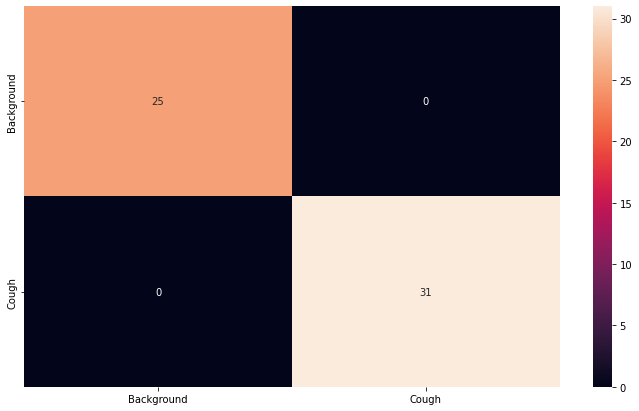

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0
  y_pred = []
  y_true = []

  with torch.no_grad():
    for data in val_dl:
      inputs, labels = data[0].to(device), data[1].to(device)
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s
      outputs = model(inputs)
      output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
      y_pred.extend(output)
      y_true.extend(labels.data.cpu().numpy())
      _, prediction = torch.max(outputs,1)
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
  cf_matrix = confusion_matrix(y_true, y_pred)
  classes = ('Background', 'Cough')
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

inference(myModel, val_dl)